In [1]:
# pip install duckdb
# pip install jupysql
# pip install notebook
# pip install tabulate
# pip install sqlalchemy

In [2]:
# If on windows, this only works if you're running Jupyter as an admin
# pip install duckdb-engine

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, ticker as mtick
import seaborn as sns
import duckdb
import sqlalchemy
from datetime import date
import json
import pathlib
# import importlib
%load_ext sql

In [4]:
sns.set(
    rc={
        "figure.figsize" : (10, 6.25)
        , "axes.facecolor" : "xkcd:white"
        , "figure.facecolor" : "xkcd:parchment"
        , 'grid.color' : 'xkcd:light gray'
        , 'axes.edgecolor' : 'black'
    }
)

# Change the billboard_observation_date!

In [5]:
current_date = date.today().strftime('%Y-%m-%d')
billboard_observation_date = '2025-01-14'

In [6]:
# Set up SQL connection
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [7]:
# Replace with your filepath. Forward slashes work for both Mac and Windows
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

In [8]:
# Test connection
%sql USE raw_db;
%sql USE raw_db.billboard;

,Success


# Update upload/rank_by_name

In [9]:
# Update this for this week's rankings in upload/rank_by_name.py
# This is easier in an IDE that allows opt+arrow_key to move lines up and down

In [10]:
# TODO: figure out importlib.reload() here so I don't have to kill the kernel to reload
from upload.rank_by_name import rankings
# from upload.backfill_rank_by_name import rankings

if len(rankings) != 50:
    print(f'{len(rankings)} rankings, but expected 50')

rankings[:5] + ['...'] + rankings[45:]

['A Bar Song (Tipsy)',
 'Smile',
 'I Had Some Help',
 'Love Somebody',
 'High Road',
 '...',
 'Neon Moon',
 'Hometown Home',
 'Baggage',
 'Last Of My Kind',
 'Use Me']

In [11]:
%%sql df_song_labeled <<
SELECT
    ss.song_id
    , ss.song_name
    , art.artist_name
    , s2a.relationship_type
    , ss.untracked_weeks_on_chart
FROM song ss
LEFT JOIN song_to_artist s2a
    ON ss.song_id = s2a.song_id
LEFT JOIN artist art
    ON s2a.artist_id = art.artist_id
;

In [12]:
existing_song_to_rank = {}
new_song_to_rank = {}
for song, rank_ix in zip(rankings, range(1,51)):
    n_rows = df_song_labeled[df_song_labeled['song_name'] == song]['song_id'].count()
    if n_rows == 0:
        new_song_to_rank[song] = rank_ix
    else:
        print(df_song_labeled.loc[df_song_labeled['song_name'] == song].to_markdown())
        song_id = input("Please enter the song_id or 'New Song'\n")

        if song_id == '': # hit enter to take the most common song ID
            song_id = int(
                df_song_labeled.loc[
                    df_song_labeled['song_name'] == song
                ]['song_id'].mode()
            )
        
        if str(song_id).lower() == 'new song':
            new_song_to_rank[song] = rank_ix
        else:
            existing_song_to_rank[int(song_id)] = rank_ix

|    |   song_id | song_name          | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:-------------------|:--------------|:--------------------|---------------------------:|
| 26 |        34 | A Bar Song (Tipsy) | Shaboozey     | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:------------|:--------------|:--------------------|---------------------------:|
| 207 |       248 | Smile       | Morgan Wallen | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name       | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:----------------|:--------------|:--------------------|---------------------------:|
|  29 |        38 | I Had Some Help | Morgan Wallen | Other main artist   |           

|    |   song_id | song_name   | artist_name      | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:-----------------|:--------------------|---------------------------:|
| 18 |        26 | Holy Smokes | Bailey Zimmerman | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:------------|:--------------|:--------------------|---------------------------:|
|  37 |        47 | High Road   | Jessie Murph  | Other main artist   |                          0 |
| 194 |       232 | High Road   | Zach Bryan    | Lead artist         |                          0 |
| 221 |        47 | High Road   | Koe Wetzel    | Lead artist         |                          0 |
Please enter the song_id or 'New Song'
232
|     |   song_id | song_name     | artist_name   | relationship_type   |   untracked_weeks_on_chart |


Please enter the song_id or 'New Song'

|     |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:------------|:--------------|:--------------------|---------------------------:|
| 147 |       178 | Darlin'     | Chase Matthew | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|    |   song_id | song_name   | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|---:|----------:|:------------|:--------------|:--------------------|---------------------------:|
| 86 |       107 | Porch Light | Josh Meloy    | Lead artist         |                          0 |
Please enter the song_id or 'New Song'

|     |   song_id | song_name    | artist_name   | relationship_type   |   untracked_weeks_on_chart |
|----:|----------:|:-------------|:--------------|:--------------------|---------------------------:|
| 208 |       249 | Single Again | Josh Ross     | Lead artist         | 

In [ ]:
# Be aware that some "last week on chart" are one too high. Audit, esp. when the song is marked new in backfillery

# Notes
#### s2a for:

#### Untracked weeks to 0 for


In [13]:
# Check that you have 50 songs
print(len(existing_song_to_rank), '+')
print(list(new_song_to_rank.keys()))

49 +
['Use Me']


### Add artists on any new songs that aren't in the artist table yet to its CSV

In [14]:
df_artist = pd.read_csv('source_data/artist.csv')

Use Me: Zach Top(53)

In [15]:
new_song_artists = [
    'Zach Top'
]
df_artist[df_artist['artist_name'].isin(new_song_artists)]

,artist_id,artist_name,pct_female,last_update
52,53,Zach Top,0.0,2024-08-23


In [16]:
df_artist['artist_id'].max()

126

In [18]:
df_artist = pd.concat(
    [
        df_artist
        , pd.DataFrame(
            np.array([
                [127, 'Josh Ross', 0, current_date]
                , [128, 'LOCASH', 0, current_date]
            ])
            , columns = ['artist_id', 'artist_name', 'pct_female', 'last_update']
        )
    ]
    , ignore_index = True
)

In [20]:
df_artist.to_csv('source_data/artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2025-01-07


### Add all new songs to the song table CSV

In [16]:
df_song_raw = pd.read_csv('source_data/song.csv')

In [17]:
# Reduce untracked weeks by one for everything being added by backfill
if input('Is this a backfill (1/0)): ') == '1':
    print('-= untracked weeks update running!')
    df_song_raw \
        .loc[
            df_song_raw['song_id'].isin(existing_song_to_rank.keys())
            , 'untracked_weeks_on_chart'
        ] -= 1

Is this a backfill (1/0)): 


In [18]:
max_song_id = df_song_raw['song_id'].max()
array_new_songs = []
for song_name in list(new_song_to_rank.keys()):
    max_song_id += 1
    array_new_songs += [[max_song_id, song_name, 0, current_date]]

array_new_songs

[[251, 'Use Me', 0, '2025-01-14']]

In [19]:
df_song_raw = pd.concat(
    [
        df_song_raw
        , pd.DataFrame(
            np.array(array_new_songs)
            , columns = ['song_id', 'song_name', 'untracked_weeks_on_chart', 'last_update']
        )
    ]
    , ignore_index = True
)
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
249,250,Hometown Home,0.0,2025-01-07
250,251,Use Me,0,2025-01-14


In [ ]:
df_song_raw[df_song_raw['song_name'].isin([
    # 'Your Place'
])]

Use Me: Zach Top(53)

In [ ]:
# Adjust untracked weeks if they aren't zero
for song_id, untracked_weeks in [
    (207, 5)
]:
    df_song_raw.loc[
        df_song_raw['song_id'] == str(song_id)
        , 'untracked_weeks_on_chart'
    ] = untracked_weeks

In [20]:
df_song_raw[-len(array_new_songs)-1:]

,song_id,song_name,untracked_weeks_on_chart,last_update
249,250,Hometown Home,0.0,2025-01-07
250,251,Use Me,0,2025-01-14


In [21]:
df_song_raw.to_csv('source_data/song.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2025-01-14


#### Add all new songs to the song_to_artist table CSV

Use Me: Zach Top(53)

In [25]:
df_s2a_raw = pd.read_csv('source_data/song_to_artist.csv').fillna('')

In [22]:
array_new_s2a = []
for s2a in [ # song_id, artist_id, relationship_conjunction, relationship_index
    [251, 53, '', '']
]:
    if s2a[3] == '': # Only lead artists don't have a relationship index
        reln = 'Lead artist'
    elif s2a[2] == '': # Featured artists don't have an explicit relationship conjunction
        reln = 'Featured artist' 
    else:
        reln = 'Other main artist'
        
    array_new_s2a += [[
        '-'.join([str(s2a[0]), reln, str(s2a[3])])
        , s2a[0]
        , s2a[1]
        , reln
        , s2a[2]
        , s2a[3]
        , current_date
    ]]
    
array_new_s2a

[['251-Lead artist-', 251, 53, 'Lead artist', '', '', '2025-01-14']]

In [26]:
df_s2a_raw = pd.concat(
    [
        df_s2a_raw
        , pd.DataFrame(
            np.array(array_new_s2a)
            , columns = [
                'song_to_artist_pk'
                , 'song_id'
                , 'artist_id'
                , 'relationship_type'
                , 'relationship_conjunction'
                , 'relationship_index'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
)
df_s2a_raw.tail(1)

,song_to_artist_pk,song_id,artist_id,relationship_type,relationship_conjunction,relationship_index,last_update
318,251-Lead artist-,251,53,Lead artist,,,2025-01-14


In [27]:
df_s2a_raw.to_csv('source_data/song_to_artist.csv', index=False)
print('Done for', billboard_observation_date)

Done for 2025-01-14


#### Convert new_song_to_rank to the id_to_rankix format of existing_song_to_rank
Then stack the two dicts of songs and insert to CSV with more info like current_date for last_update

In [28]:
all_song_to_rank = existing_song_to_rank.copy()
for song_name, rank in new_song_to_rank.items():
    songs = list(df_song_raw[df_song_raw['song_name'] == song_name]['song_id'])
    
    if len(songs) == 1:
        song_id = songs[0]
    elif len(songs) > 1:
        song_id = int(input(f'{str(songs)}: Choose ID of song actually at rank {rank}\n'))
    else:
        raise Exception(f'The song at rank {rank} is missing from the song CSV')
    
    all_song_to_rank[int(song_id)] = rank

array_new_ranking = [
    [
        '-'.join([billboard_observation_date, str(rank)])
        , billboard_observation_date
        , rank
        , song_id
        , current_date
    ]
    for song_id, rank
    in all_song_to_rank.items()
]

array_new_ranking[45:] # should be 5 rows, new songs come at end

[['2025-01-14-46', '2025-01-14', 46, 236, '2025-01-14'],
 ['2025-01-14-47', '2025-01-14', 47, 250, '2025-01-14'],
 ['2025-01-14-48', '2025-01-14', 48, 227, '2025-01-14'],
 ['2025-01-14-49', '2025-01-14', 49, 240, '2025-01-14'],
 ['2025-01-14-50', '2025-01-14', 50, 251, '2025-01-14']]

In [29]:
pd.concat(
    [
        pd.read_csv('source_data/billboard_ranking.csv').fillna('')
        , pd.DataFrame(
            np.array(array_new_ranking)
            , columns = [
                'billboard_ranking_pk'
                , 'billboard_observation_date'
                , 'billboard_rank'
                , 'song_id'
                , 'last_update'
            ]
        )
    ]
    , ignore_index = True
).to_csv('source_data/billboard_ranking.csv', index=False)

print('Done for', billboard_observation_date)

Done for 2025-01-14


## Push to duckdb

In [30]:
# TODO: instead of purging and rebuilding, use the raw data to run updates
%sql --close duckdb:///C:/Users/Admin/billboard/raw_db.duckdb --quiet
pathlib.Path('raw_db.duckdb').unlink(missing_ok = True)

#### TODO: integrate into jupyter using `%python`

In a command terminal
- `python table_configs/run_schema_configs.py billboard_schema.sql`
- `python table_configs/run_table_configs.py`
- `python main.py`

In [31]:
%sql duckdb:///C:/Users/Admin/billboard/raw_db.duckdb

## Run the ranking SQL script

In [125]:
# Set parameters for the ranking
weeks_lookback = 35 # Arbitrary lookback
n_weeks_for_recent = 20 # Arbitrary definition of recency, aligned with when bottom half of the chart
    # Compare to: 1, 13, 20, 26, 52
floor_avg_weeks = 1.5
value_metric = 'recent_weeks_main_artist'

In [126]:
with duckdb.connect('raw_db.duckdb') as conn:
    for weeks_ago in range(weeks_lookback):
        if weeks_ago == 0:
            with open('analysis/artist_ranking.sql') as sql_file:
                artist_ranking = conn.sql(
                    sql_file.read().format(
                        weeks_ago = str(weeks_ago)
                        , n_weeks_for_recent = str(n_weeks_for_recent)
                    )
                )
                df_artist_ranking = pd.DataFrame(
                    data=artist_ranking.fetchall()
                    , columns=artist_ranking.columns
                )

        else: # Have to close and reopen file between executions for fetchall() to work
            with open('analysis/artist_ranking.sql') as sql_file:
                prev_artist_ranking = conn.sql(
                    sql_file.read().format(
                        weeks_ago = str(weeks_ago)
                        , n_weeks_for_recent = str(n_weeks_for_recent)
                    )
                )
                df_artist_ranking = pd.concat([
                    df_artist_ranking
                    , pd.DataFrame(
                        data=prev_artist_ranking.fetchall()
                        , columns=artist_ranking.columns
                    )
                ])

In [127]:
#! TOFIX all time metrics need to exclude future weeks
# TODO make this show NA() for lookback windows with zero artist song credits
# TODO: this, but just for all artists on this week's chart

df_artist_ranking_over_time = df_artist_ranking.pivot(
    index = 'artist_name'
    , columns = 'weeks_ago'
    , values = 'artist_rank'
).sort_values(0)

df_artist_ranking_over_time.loc[:, -4:][: 10]

weeks_ago,-4,-3,-2,-1,0
artist_name,,,,,
Post Malone,1,1,1,1,1
Morgan Wallen,3,3,3,2,2
Jelly Roll,4,4,4,3,3
Zach Bryan,2,2,2,4,4
Zach Top,5,5,5,5,5
Dylan Scott,6,6,6,6,6
Shaboozey,8,7,7,7,7
Riley Green,9,9,8,8,8
Koe Wetzel,7,8,9,9,9


In [128]:
# Above, but for every artist on this week's chart
## TODO
# current_chart_artists = ['Post Malone', 'Megan Moroney'] # example
# df_scratch = df_artist_ranking_over_time.loc[current_chart_artists, -4:]

# df_scratch
# df_scratch.style.apply(lambda row: np.where(row.index.isin(["Post Malone", "-2"]), "background-color:green", "background-color:red"), axis=1)
# # TODO: And last week's chart if they fell off

# color_by_ix = {}
# for ix in list(df_scratch.index):
#     if ix in ['Post Malone']:
#         color_by_ix[ix] = 'background-color:green' # Does this need to be a whole generator?
#     else:
#         color_by_ix[ix] = 'background-color:red' # Once this works, just make this ''
            
# df_artist_ranking_over_time.apply(color_by_ix, axis=1)

In [129]:
# Limit to just artists with currently enough song-weeks over the lookback
top_artists = list(
    df_artist_ranking[
        (df_artist_ranking[value_metric] > floor_avg_weeks * n_weeks_for_recent)
        & (df_artist_ranking['weeks_ago'] == 0)
    ]['artist_id']
)

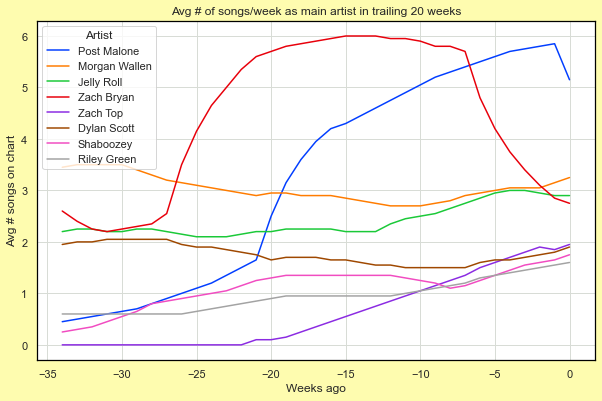

In [130]:
value_metric = 'recent_weeks_main_artist' # 'recent_weeks_artist' to include featured song weeks
graph = sns.lineplot(
    data = df_artist_ranking[
        df_artist_ranking['artist_id'].isin(top_artists)
      ].pivot(
        index = 'artist_name'
        , columns = 'weeks_ago'
        , values = value_metric
      ).loc[
         df_artist_ranking_over_time[0].keys()[:len(top_artists)] # maintain order from rank
      ].fillna(np.inf).T 
      / n_weeks_for_recent
    , dashes = False
    , palette = 'bright'
)

more_than_one_week = 0
if n_weeks_for_recent > 1:
    more_than_one_week += 1
    
graph.set(
    title = 'Avg # of songs/week as main artist in trailing {} week{}'.format(
        n_weeks_for_recent
        , ''.join((more_than_one_week * ['s']))
    )
    , ylabel = 'Avg # songs on chart'
    , xlabel = 'Weeks ago'
)

plt.legend(title = 'Artist')
graph.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))

plt.show()

In [131]:
# Current artist rankings
pd.set_option('display.max_rows', 115)
cols = list(df_artist_ranking.columns)
col_nums = { col:ix for (col,ix) in zip(cols, range(len(cols))) }
df_artist_ranking_compact = df_artist_ranking.rename(columns = col_nums)
df_artist_ranking_compact \
    .loc[:, 1 : len(cols) - 2 ][
        (df_artist_ranking['weeks_ago'] == 0)
        # & (df_artist_ranking['artist_name'].isin(current_artists))
].head(100)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,Post Malone,0,103,103,103,149,154,154,14,14,14,19,20,20,+2,+2,+1,1,2024-04-09
1,Morgan Wallen,0,39,65,77,253,299,348,4,6,7,8,11,13,+1,+1,+1,1,2024-01-06
2,Jelly Roll,0,42,58,81,138,196,244,4,5,7,8,10,12,+3,+3,+3,3,2024-01-06
3,Zach Bryan,0,55,55,55,352,352,352,5,5,5,30,30,30,+5,+5,+1,1,2024-01-06
4,Zach Top,0,39,39,39,41,41,41,4,4,4,4,4,4,+8,+8,+8,8,2024-08-23
5,Dylan Scott,0,20,38,38,62,109,109,2,3,3,2,3,3,+18,+18,+18,18,2024-01-06
6,Shaboozey,0,35,35,35,61,61,61,3,3,3,5,5,5,+1,+1,+1,1,2024-04-26
7,Riley Green,0,32,32,49,77,77,103,3,3,4,4,4,5,+24,+7,+15,7,2024-01-06
8,Koe Wetzel,0,27,27,27,60,60,60,3,3,3,4,4,4,+4,+4,+4,4,2024-03-19
9,Ella Langley,0,26,26,38,35,37,49,2,2,3,2,3,4,+7,+7,+7,7,2024-02-10


In [98]:
# As above, but changes rather than current status
pd.options.display.float_format = '{:+,.0f}'.format
df_artist_ranking_change = df_artist_ranking.copy()[
    (df_artist_ranking['weeks_ago'] == 0)
    & (df_artist_ranking['recent_weeks_artist'] != 0)
]
df_artist_ranking_change.drop(['artist_debut_date_in_data'], axis = 1, inplace = True)
ranking_cols = list(df_artist_ranking_change.columns)

for row in df_artist_ranking_change.iterrows():
    this_artist = row[1]['artist_id']
    this_change_row = df_artist_ranking_change[
        df_artist_ranking_change['artist_id'] == this_artist
    ]
    row_last_week = df_artist_ranking[
        (df_artist_ranking['weeks_ago'] == -1)
        & (df_artist_ranking['artist_id'] == this_artist)
    ]
    for col_name, val_this_week in row[1][3:].items():
        val_last_week = np.array(row_last_week[col_name])[0]
        val_change = round(val_this_week - val_last_week, 0)
        
        if col_name in ['artist_rank', 'recent_peak_position']:
            if val_change > 0: # Higher numbers are "lower" on the chart
                str_change = '↘ ' + str(round(val_change))
            elif val_change == 0:
                str_change = ''
            elif val_change < 0: # Lower numbers are "higher" on the chart
                str_change = '↗ ' + str(round(abs(val_change)))
                
        else:
            val_change = val_this_week - val_last_week
            if val_change > 0:
                str_change = '+' + str(val_change)
            elif val_change == 0:
                str_change = ''
            elif val_change < 0:
                str_change = str(val_change)
        
        df_artist_ranking_change.loc[this_change_row.index[0], col_name] = str_change


df_changes = df_artist_ranking_change[[
    'artist_name'
    , 'artist_rank'
    , 'recent_weeks_main_artist'
    , 'recent_weeks_lead_artist'
    , 'recent_weeks_artist'
    , 'recent_num_songs_main_artist'
    , 'recent_num_songs_lead_artist'
    , 'recent_num_songs_artist'
    , 'recent_peak_position'
]]

df_changes.columns = [
    'Artist'
    , 'Rank'
    , 'Weeks (Main)' # TODO: multilevel column index
    , 'Weeks (Lead)'
    , 'Weeks (Any)'
    , 'Songs (Main)'
    , 'Songs (Lead)'
    , 'Songs (Any)'
    , 'L26W Peak Position'
]

df_changes.style.set_properties(**{'text-align': 'left'})
# df_changes.style.set_sticky(axis = 1) # TOFIX

,Artist,Rank,Weeks (Main),Weeks (Lead),Weeks (Any),Songs (Main),Songs (Lead),Songs (Any),L26W Peak Position
0,Morgan Wallen,,,,,,,,
1,Post Malone,,,,,,,,↘ 1
2,Shaboozey,,,,,,,,
3,Jelly Roll,,,,,,,,↘ 1
4,Zach Top,↗ 7,+1,+1,+1,+1,+1,+1,↘ 1
5,Riley Green,,,,,,,,↗ 3
6,Kelsea Ballerini,↗ 26,+1,+1,+1,+1,+1,+1,↗ 4
7,Dylan Scott,↘ 1,,,,,,,
8,Ella Langley,↘ 1,,,,,,,↗ 1
9,Blake Shelton,↘ 1,,,,,,,


In [90]:
%%sql df_weeks_for_artist <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
    , s2a.artist_id
    , art.artist_name
    , s2a.relationship_type
    , art.pct_female
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
LEFT JOIN raw_db.billboard.song_to_artist s2a
    ON br.song_id = s2a.song_id
LEFT JOIN raw_db.billboard.artist art
    ON s2a.artist_id = art.artist_id
ORDER BY 1 ASC

In [40]:
df_by_reln_type = df_weeks_for_artist.groupby(
        ['billboard_observation_date', 'relationship_type']
    ).agg(['mean', 'count'])['pct_female'].reset_index()
df_by_reln_type['wtd_avg_numerator'] = df_by_reln_type['mean'] * df_by_reln_type['count']

df_all_credits = df_by_reln_type.groupby('billboard_observation_date').sum()
df_all_credits['mean'] = df_all_credits['wtd_avg_numerator'] / df_all_credits['count']
df_all_credits.reset_index(inplace = True)
df_all_credits['relationship_type'] = 'All credited artists'

df_mains = df_by_reln_type[
    df_by_reln_type['relationship_type'].isin(['Lead artist', 'Other main artist'])
].groupby('billboard_observation_date').sum()
df_mains['mean'] = df_mains['wtd_avg_numerator'] / df_mains['count']
df_mains.reset_index(inplace = True)
df_mains['relationship_type'] = 'All main artists'

col_order = [
    'billboard_observation_date'
    , 'relationship_type'
    , 'mean'
    , 'count'
    , 'wtd_avg_numerator'
]

df_pct_female = pd.concat([
    df_by_reln_type
    , df_all_credits[col_order]
    , df_mains[col_order]
])

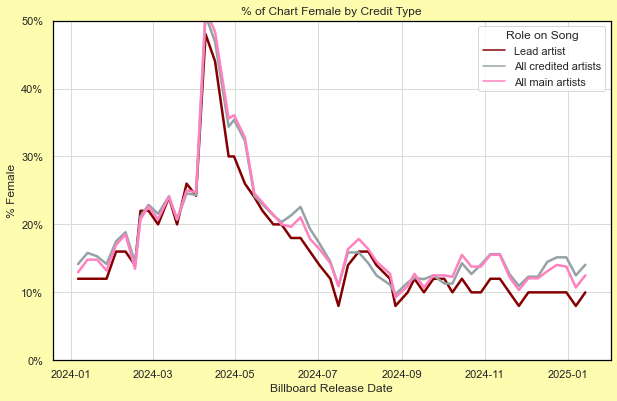

In [41]:
palette = {
    'Lead artist' : 'xkcd:dark red'
    , 'All main artists' : 'xkcd:pink'
    , 'All credited artists' : 'xkcd:cool gray'
}

graph = sns.lineplot(
    data = df_pct_female[
        df_pct_female['relationship_type'].isin(palette.keys())
    ]
    , x = 'billboard_observation_date'
    , y = 'mean'
    , hue = 'relationship_type'
    , palette = palette
    , linewidth = 2.5
).set(
    title = '% of Chart Female by Credit Type'
    , xlabel = 'Billboard Release Date' # Really observation date (for now)
    , ylabel = '% Female'
    , ylim = [0, 0.5]
)

plt.legend(title = 'Role on Song')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))

## Show WoW distribution of songs with female artists
TODO: turn into a series of overlapping density charts

In [42]:
pd.options.display.float_format = "{:,.2f}".format

In [134]:
%%sql df_cumulative_pct_female <<
WITH cte_song_pct_female AS (
    SELECT
        br.billboard_observation_date
        , br.song_id
        , br.billboard_rank
        , AVG(art.pct_female) AS song_pct_female
    FROM raw_db.billboard.billboard_ranking br
    INNER JOIN raw_db.billboard.song_to_artist s2a
        ON br.song_id = s2a.song_id
        AND s2a.relationship_type IN ('Lead artist', 'Other main artist')
    LEFT JOIN raw_db.billboard.artist art
        ON s2a.artist_id = art.artist_id
    WHERE billboard_observation_date >= (
        SELECT MAX(billboard_observation_date)
        FROM raw_db.billboard.billboard_ranking
    ) - 14 --# This week and preceding two weeks is about all the chart can handle
    # WHERE billboard_observation_date IN ('2024-08-23', '2024-12-31', '2024-04-16')
    GROUP BY 1,2,3
)
SELECT
    billboard_observation_date
    , billboard_rank
    , song_pct_female AS this_song_pct_female
    , SUM(song_pct_female) OVER(
        PARTITION BY billboard_observation_date
        ORDER BY billboard_rank ASC
        ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      )
      / COUNT(1) OVER (
          PARTITION BY billboard_observation_date
          ORDER BY billboard_rank ASC
          ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW
      ) AS cumulative_pct_female
FROM cte_song_pct_female
GROUP BY 1,2,3
ORDER BY 1 DESC, 2 ASC

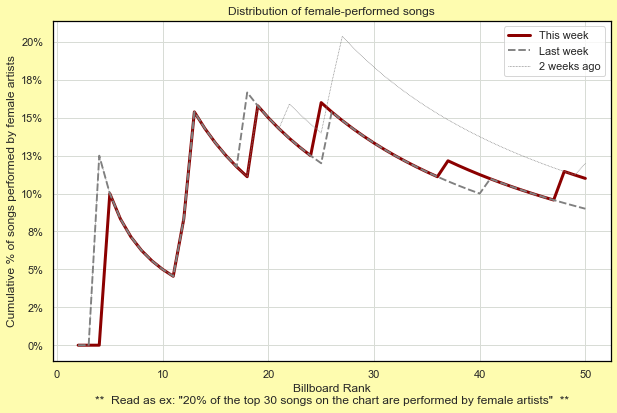

In [135]:
graph = sns.lineplot(
    data = df_cumulative_pct_female[df_cumulative_pct_female['billboard_rank'] > 1]
    , y = 'cumulative_pct_female'
    , x = 'billboard_rank'
    , palette = ['darkred', 'grey', 'grey']
    , hue = 'billboard_observation_date'
    , size = 'billboard_observation_date'
    , style = 'billboard_observation_date'
    , legend = False # hue and size/style treat date-type differently, so duplicate in the legend
)

plt.legend(['This week', 'Last week', '2 weeks ago'])
plt.title('Distribution of female-performed songs')
plt.xlabel(
    'Billboard Rank\n'
    + '**  Read as ex: "20% of the top 30 songs on the chart are performed by female artists"  **'
)
plt.ylabel('Cumulative % of songs performed by female artists')
graph.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:.0%}'))

In [47]:
credit_type_to_linestyle = {
    'Lead artist' : 'solid'
    , 'Other main artist' : 'dashed'
    , 'Featured artist' : 'dotted'
}

In [48]:
# TODO enrich with n_songs from above
df_weeks_for_artist[
    df_weeks_for_artist['billboard_observation_date'] == billboard_observation_date
].groupby('artist_name').count().iloc[:,1].loc[
    lambda x: x > 1
    # lambda x: x == 1
].sort_values(ascending = False)

artist_name
Morgan Wallen       5
Post Malone         4
Jelly Roll          3
Shaboozey           3
Blake Shelton       2
Dylan Scott         2
Ella Langley        2
Kelsea Ballerini    2
Riley Green         2
Zach Top            2
Name: song_id, dtype: int64

Smile: Morgan Wallen(2)
Single Again: Josh Ross(127)
Hometown Home: LOCASH(128)

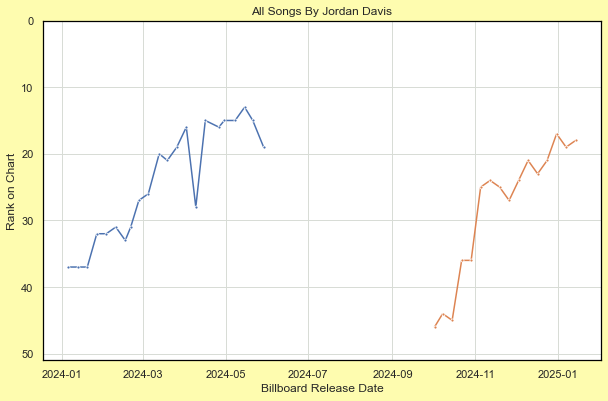

In [62]:
# For now, manual artist name selection
# TODO: Create charts for every artist on this week's chart at once
artist_name = 'Jordan Davis'

df_weeks_this_artist = df_weeks_for_artist.query(
    f"artist_name == '{artist_name}'"
)

## TODO add groupby
# if df_weeks_this_artist['artist_id'].count().count() > 1:
#     this_artist_id = input("Please input artist ID for differentiation")
#     df_weeks_this_artist[
#         df_weeks_this_artist[artist_id] == this_artist_id
#     ]

for _, row in df_weeks_this_artist.pivot( # TODO no pivot to support legend in char 'song_name'
    index = 'song_id'
    , columns = 'billboard_observation_date' #TODO: weeks ago
    , values = 'billboard_rank'
).fillna(
    np.inf # suppresses only if a different song is on the chart that week
).iterrows():
    graph = sns.lineplot(
        data = row
        , linestyle = credit_type_to_linestyle[
            df_weeks_this_artist[
                df_weeks_this_artist['song_id'] == row.name
            ].groupby('relationship_type').count().iloc[0].name
        ]
        , marker = '.'
    )
    
graph.set(
    title = f'All Songs By {artist_name}'
    , xlabel = 'Billboard Release Date' # Really observation date (for now)
    , ylabel = 'Rank on Chart'
    , ylim = [0, 51]
)
graph.axes.invert_yaxis()

In [63]:
# TODO: Set comparison_observation_date as num weeks back, not specific date
current_observation_date = billboard_observation_date
comparison_observation_date = '2024-12-31'

with duckdb.connect('raw_db.duckdb') as conn:
    with open('analysis/removed_songs.sql') as sql_file:
        removed_songs = conn.sql(
            sql_file.read().format(
                current_observation_date
                , comparison_observation_date
            )
        )
    print(removed_songs)

┌─────────┬────────────────────────────┬────────────────┐
│ song_id │         song_name          │ ranking_before │
│  int32  │          varchar           │     int32      │
├─────────┼────────────────────────────┼────────────────┤
│      57 │ 28                         │             20 │
│     244 │ Maybe This Christmas       │             22 │
│     246 │ Driving Home For Christmas │             27 │
│     243 │ Georgia Ways               │             39 │
│     239 │ Bad Luck                   │             43 │
│     241 │ Thoughts Of You            │             45 │
│     210 │ Gonna Love You             │             48 │
└─────────┴────────────────────────────┴────────────────┘



In [68]:
# TODO consider adding a measurement start date column
    # for Friday of each week based on observation date

In [64]:
%%sql df_weeks <<
SELECT
    br.billboard_observation_date
    , br.song_id
    , ss.song_name
    , br.billboard_rank
FROM raw_db.billboard.billboard_ranking br
LEFT JOIN raw_db.billboard.song ss
    ON br.song_id = ss.song_id
ORDER BY 1 ASC

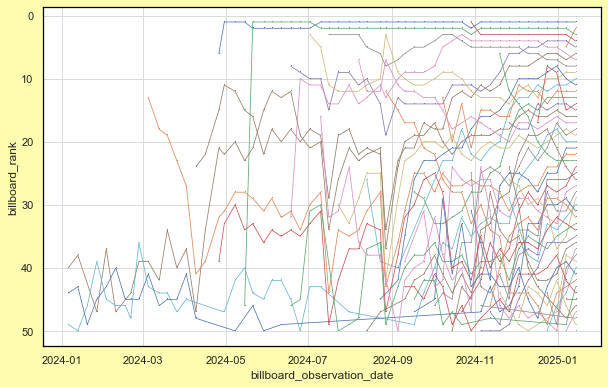

In [65]:
for _, row in df_weeks.query(
    # f"billboard_observation_date == '2024-09-10'"
    f"billboard_observation_date == '{billboard_observation_date}'"
).sort_values('billboard_rank').iterrows():
    this_song = df_weeks[
        df_weeks['song_id'] == row['song_id']
    ].sort_values('billboard_observation_date').fillna(
        np.inf # Not working fully to show gaps as missing
    )
    
    graph = sns.lineplot(
        data = this_song
        , x = 'billboard_observation_date' # TODO: weeks back instead of obs date
        , y = 'billboard_rank'
        , marker = ',' # TODO: add back with bigger chart
        , dashes = False
        , linewidth = 0.75
        # , hue='k' # Not working with error 'cannot be assigned with wide-form data'
    )#.set_title(this_song.reset_index()['song_name'][0])
    
graph.axes.invert_yaxis()
# TODO: Make this about 4x bigger

In [59]:
# TODO maybe: Each song on its own tile, rather than overlapped